In [1]:
using ModelingToolkit
using DifferentialEquations
using Plots
using ModelingToolkit: t_nounits as t, D_nounits as D, @variables, @parameters, @named, @unpack, @mtkbuild
using Symbolics

In [2]:
mutable struct Wall
    rho::Float64
    V::Float64
    m::Float64
    Cp::Float64
    m_elem::Float64
end
mutable struct Ref
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    Ge1::Float64
    Ge2::Float64
end
mutable struct Fld
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    k::Float64
    Pr::Float64
    rho::Float64
    mu::Float64
    Cp::Float64
    mdot::Float64
    T_in::Float64
end
mutable struct HX_PHX
    N_t::Int64
    N_c::Int64
    N_f::Int64
    L_w::Float64
    L_v::Float64
    A_t::Float64
    phi::Float64
    p::Float64
    t::Float64
    b::Float64
    D_h::Float64
    beta::Float64
    N_CV::Int64
    Wall::Wall
    Ref::Ref
    Fld::Fld
    isCounterFlow::Bool
end

SymHX = Symbolics.symstruct(HX_PHX)

Symbolics.Struct{HX_PHX}

In [3]:
function make_HX(N_t::Int64, L_w::Float64, L_v::Float64, A_t::Float64, p::Float64, t::Float64, N_CV::Int64, isCounterFlow::Bool)
    # DIC-193-33 판형 열교환기. http://www.dibr.co.kr/exchanger/detail/D93RP00056?ts=1735978818&capacity=0.5&cate=162&
    N_t = N_t
    N_c = (N_t - 1) / 2
    N_f = (N_t - 1) / 2
    L_w = L_w
    L_v = L_v
    A_t = A_t
    phi = A_t / (L_w * L_v * (N_t - 2))
    p = p
    t = t
    b = p - t 
    D_h = 2 * b / phi
    beta = 25 * pi / 180
    N_CV = N_CV

    # Wall 관련 물성, 기하
    Wall_rho = 7.93e3 # STS 304 밀도
    Wall_V = A_t * t
    Wall_m = Wall_V * Wall_rho
    Wall_Cp = 502 # 비열

    # Ref, Fld 기하
    Ref_V = N_c * L_w * b* L_v
    Ref_A_cs = N_c * L_w * b
    Fld_V =  N_f * L_w * b * L_v
    Fld_A_cs = N_f * L_w * b

    # Element별 기하
    Wall_m_elem = Wall_m / N_CV
    Ref_V_elem = Ref_V / N_CV
    Ref_A_elem = A_t / N_CV
    Fld_V_elem = Fld_V / N_CV
    Fld_A_elem = Ref_A_elem

    # Ref UA 관련 물성
    Ref_Ge1 = 11.22*(b/D_h)^(-2.83) * (pi/2 - beta)^(-4.5)
    Ref_Ge2 = 0.35*(b/D_h)^(0.23) * (pi/2 - beta)^(1.48)

    # Fld 관련 물성(물, 15도, 포화액, refprop 기준)
    Fld_k = 0.5887
    Fld_Pr = 1.7058
    Fld_rho = 999.0561
    Fld_mu = 0.0011
    Fld_Cp = 4.1888e3

    # Fld
    Fld_mdot = 0.1
    Fld_T_in = 273.15 + 40
    isCounterFlow = isCounterFlow

    HX_Wall = Wall(Wall_rho, Wall_V, Wall_m, Wall_Cp, Wall_m_elem)
    HX_Ref = Ref(Ref_V, Ref_A_cs, Ref_V_elem, Ref_A_elem, Ref_Ge1, Ref_Ge2)
    HX_Fld = Fld(Fld_V, Fld_A_cs, Fld_V_elem, Fld_A_elem, Fld_k, Fld_Pr, Fld_rho, Fld_mu, Fld_Cp, Fld_mdot, Fld_T_in)
    return HX_PHX(N_t, N_c, N_f, L_w, L_v, A_t, phi, p, t, b, D_h, beta, N_CV, HX_Wall, HX_Ref, HX_Fld, isCounterFlow)
end
# HX_E 기본 
HX_E_N_t = 33
HX_E_L_w = 0.083
HX_E_L_v = 0.154
HX_E_A_t = 0.434
HX_E_p = 2.35e-3
HX_E_t = 0.4e-3
HX_E_N_CV = 20
HX_E_isCounterFlow = true
HX_E = make_HX(HX_E_N_t, HX_E_L_w, HX_E_L_v, HX_E_A_t, HX_E_p, HX_E_t, HX_E_N_CV, HX_E_isCounterFlow)

HX_PHX(33, 16, 16, 0.083, 0.154, 0.434, 1.095290251916758, 0.00235, 0.0004, 0.0019500000000000001, 0.0035607, 0.4363323129985824, 20, Wall(7930.0, 0.00017360000000000002, 1.376648, 502.0, 0.0688324), Ref(0.0003987984000000001, 0.0025896000000000005, 1.9939920000000003e-5, 0.0217, 34.95278503589673, 0.3672934117781399), Fld(0.0003987984000000001, 0.0025896000000000005, 1.9939920000000003e-5, 0.0217, 0.5887, 1.7058, 999.0561, 0.0011, 4188.8, 0.1, 313.15), true)

In [16]:
# Q11. MTK ver
using CoolProp
# CoolProp 함수들을 MTK에 등록합니다. (추후 Tabular 값으로 변경)
 # ρ, T 등을 P, h에서 계산하는 함수
handle = CoolProp.AbstractState_factory("HEOS&BICUBIC", "R410A")

function R410a_density(P, h)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("HmassP_INPUTS"), h, P)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end

function R410a_temperature(P, h)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("HmassP_INPUTS"), h, P)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("T"))
end

# 건도 0, 1에서 물성 찾기 // 건도 0에서 열물성 계산
function R410a_h_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Hmass"))
end
function R410a_h_V(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 1)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Hmass"))
end
function R410a_rho_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end
function R410a_rho_V(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 1)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end

function R410a_k_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("L"))
end
function R410a_mu_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("V"))
end
function R410a_Pr_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Prandtl"))
end

R410a_x(P,h) = (h - R410a_h_L(P)) / (R410a_h_V(P) - R410a_h_L(P))

# Symbolics에 등록
@register_symbolic R410a_density(P, h) 
@register_symbolic R410a_temperature(P, h)

@register_symbolic R410a_h_L(P)
@register_symbolic R410a_h_V(P)
@register_symbolic R410a_rho_L(P)
@register_symbolic R410a_rho_V(P)

@register_symbolic R410a_k_L(P)
@register_symbolic R410a_mu_L(P)
@register_symbolic R410a_Pr_L(P)

@register_symbolic R410a_x(P, h)

# Symbolics에 사용할 미분 연산 정의
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{1}) = R410a_density(args[1]+1, args[2]) -  R410a_density(args[1], args[2])
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{2}) = R410a_density(args[1], args[2]+1) -  R410a_density(args[1], args[2])

In [17]:
# UA_elem의 연산 함수 등록
function U_func(P, h, mdot_in, HX_Arr)
    x = R410a_x(P, h)
    ref_k_L = R410a_k_L(P)
    ref_mu_L = R410a_mu_L(P)
    ref_Pr_L = R410a_Pr_L(P)
    ref_rho_L = R410a_rho_L(P)
    ref_rho_V = R410a_rho_V(P)
    
    HX_D_h = HX_Arr[1]
    HX_beta = HX_Arr[2]
    HX_Ref_A_cs = HX_Arr[3]
    HX_Ref_Ge1 = HX_Arr[4]
    HX_Ref_Ge2 = HX_Arr[5]

    G = ifelse(mdot_in > 0, mdot_in / HX_Ref_A_cs, 0)
    Re_L = G * HX_D_h / ref_mu_L
    U_ref_single = 0.295 * (ref_k_L/HX_D_h) * Re_L^0.64 * ref_Pr_L^0.32 * (π/2 - HX_beta)^0.09

    G_eq_tp = G * (1-x + x*(ref_rho_L/ref_rho_V)^0.5)
    Re_eq_tp = G_eq_tp * HX_D_h / ref_mu_L
    U_ref_tp = HX_Ref_Ge1 * (ref_k_L/HX_D_h) * Re_eq_tp^HX_Ref_Ge2 * ref_Pr_L^(1/3)
   
    # 기울기 계산
    slope1 = (U_ref_tp - U_ref_single) / 0.1
    slope2 = (U_ref_single - U_ref_tp) / 0.1 # slope2는 -slope1과 같음

    # 각 구간의 기울기 변화를 더하여 최종값을 계산
    U_ref = U_ref_single +
            ifelse(x > 0.0, slope1 * (x - 0.0), 0) +      # x=0에서 기울기 0 -> slope1로 증가
            ifelse(x > 0.1, -slope1 * (x - 0.1), 0) +     # x=0.1에서 기울기 slope1 -> 0으로 감소
            ifelse(x > 0.9, slope2 * (x - 0.9), 0) +      # x=0.9에서 기울기 0 -> slope2로 증가
            ifelse(x > 1.0, -slope2 * (x - 1.0), 0)       # x=1.0에서 기울기 slope2 -> 0으로 감소

    return U_ref
end

U_func (generic function with 135 methods)

In [18]:
@register_symbolic U_func(P, h, mdot_in, HX_Arr::Symbolics.Arr{Num,5})

In [19]:
function U_func_Fld(HX::HX_PHX)
    G = HX.Fld.mdot / HX.Fld.A_cs
    Re_Fld = G * HX.D_h / HX.Fld.mu
    U_ref_Fld = 0.295 * (HX.Fld.k/HX.D_h) * Re_Fld^0.64 * HX.Fld.Pr^0.32 * (π/2 - HX.beta)^0.09
    return U_ref_Fld
end

U_func_Fld (generic function with 1 method)

In [20]:
# 1. Params, Variables for Ref
N = HX_E.N_CV
U_Fld_elem = U_func_Fld(HX_E)

# 다른 Component
P_in_val = 3200e3
P_out_val = 3000e3
h_in_val = 450e3
c1_val = 9e-6
c2_val = c1_val

9.0e-6

In [21]:
@parameters begin
    HX_Arr[1:5] = [HX_E.D_h, HX_E.beta, HX_E.Ref.A_cs, HX_E.Ref.Ge1, HX_E.Ref.Ge2]

    HX_Ref_A_elem = HX_E.Ref.A_elem
    HX_Ref_V_elem = HX_E.Ref.V_elem

    HX_mdot_Fld = HX_E.Fld.mdot
    HX_T_Fld_in = HX_E.Fld.T_in
    HX_Fld_A_elem = HX_E.Fld.A_elem
    HX_Fld_Cp = HX_E.Fld.Cp
    UA_Fld_elem = U_Fld_elem * HX_E.Fld.A_elem

    HX_Wall_m_elem = HX_E.Wall.m_elem
    HX_Wall_Cp = HX_E.Wall.Cp
end

@parameters begin
    c1=c1_val 
    c2=c2_val
    P_in=P_in_val 
    P_out=P_out_val 
    h_in=h_in_val 
    ρ_in=R410a_density(P_in, h_in)
end

# 1. Variables for Ref
@variables begin
    P(t)=P_in_val # P_in_val에서 50kPa 감소
    h(t)[1:N]=h_in_val*ones(N) 
    ρ(t)[1:N] 
    T(t)[1:N]
end
@variables begin
    mdot_in(t)[1:N] 
    mdot_out(t)[1:N] 
    Q_r(t)[1:N] 
    h_out(t)[1:N] 
    UA_elem(t)[1:N]
end

# 2. Variables for Wall
@variables T_wall(t)[1:N] = HX_E.Fld.T_in*ones(N)

# 3. Variables for Fld
@variables T_Fld(t)[1:N+1] Q_f(t)[1:N]

2-element Vector{Symbolics.Arr{Num, 1}}:
 (T_Fld(t))[1:21]
 (Q_f(t))[1:20]

In [22]:
# 4. Equations
# 4-1. Evap
# 4-1.1 Evap_Ref_side
eva_Ref = [
    [
    # 1-1. Algebraic eqns for Ref
    # State vars 연산
    ρ[i] ~ R410a_density(P, h[i]), T[i] ~ R410a_temperature(P, h[i]),
    # Flow vars 연산
    mdot_in[i] ~ (i == 1 ? ifelse(P_in > P, c1 * sqrt(ρ_in * (P_in - P)), 0) : mdot_out[i-1]),
    mdot_out[i] ~ (i == N ? ifelse(P > P_out, c2 * sqrt(ρ[i] * (P - P_out)), 0) : mdot_in[i+1]),
    h_out[i] ~ h[i],
    # 열전달(Ref) 식
    UA_elem[i] ~ U_func(P, h[i], mdot_in[i], HX_Arr) * HX_Ref_A_elem,
    Q_r[i] ~ UA_elem[i] * (T_wall[i] - T[i]),
    
    # 1-2. Differential eqns for Ref
    HX_Ref_V_elem * D(ρ[i]) ~ mdot_in[i] - mdot_out[i],
    HX_Ref_V_elem * h[i] * D(ρ[i]) + HX_Ref_V_elem * ρ[i] * D(h[i]) - HX_Ref_V_elem * D(P) ~ mdot_in[i] * (i == 1 ? h_in : h_out[i-1]) - mdot_out[i] * h_out[i] + Q_r[i],
    ]
    for i in 1:N
]

if HX_E.isCounterFlow == true
    # 4-1.2 Evap_Wall_side
    eva_Wall = [
        [
            # 2-1. Algebraic eqns for Wall
            # 2-2. Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[N+1-i] - Q_r[i]
        ]
        for i in 1:N
    ]
    # 4-1.3 Evap_Fld_side
    eva_Fld = [
        [
            # 3-1. Algebraic eqns for Fld
            Q_f[N+1-i] ~ (HX_mdot_Fld * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_mdot_Fld * HX_Fld_Cp))) * (T_Fld[N+1-i] - T_wall[i]),
            Q_f[N+1-i] ~ (HX_mdot_Fld * HX_Fld_Cp) * (T_Fld[N+1-i] - T_Fld[N+2-i])
        ]
        for i in 1:N
    ]
else
    # 4-1.2 Evap_Wall_side
    eva_Wall = [
        [
            # 2-1. Algebraic eqns for Wall
            # 2-2. Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[i] - Q_r[i]
        ]
        for i in 1:N
    ]
    # 4-1.3 Evap_Fld_side
    eva_Fld = [
        [
            # 3-1. Algebraic eqns for Fld
            Q_f[i] ~ (HX_mdot_Fld * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_mdot_Fld * HX_Fld_Cp))) * (T_Fld[i] - T_wall[i]),
            Q_f[i] ~ (HX_mdot_Fld * HX_Fld_Cp) * (T_Fld[i+1] - T_Fld[i])
        ]
        for i in 1:N
    ]
end
push!(eva_Fld, [T_Fld[1] ~ HX_T_Fld_in])

# Flatten the evap models
eva_eqns = vcat(eva_Ref, eva_Wall, eva_Fld)
eva_model = [eva_eq for eva_eq_vec in eva_eqns for eva_eq in eva_eq_vec]

241-element Vector{Equation}:
 (ρ(t))[1] ~ Main.R410a_density(P(t), (h(t))[1])
 (T(t))[1] ~ Main.R410a_temperature(P(t), (h(t))[1])
 (mdot_in(t))[1] ~ ifelse(P_in > P(t), c1*sqrt((P_in - P(t))*ρ_in), 0)
 (mdot_out(t))[1] ~ (mdot_in(t))[2]
 (h_out(t))[1] ~ (h(t))[1]
 (UA_elem(t))[1] ~ HX_Ref_A_elem*Main.U_func(P(t), (h(t))[1], (mdot_in(t))[1], HX_Arr)
 (Q_r(t))[1] ~ (-(T(t))[1] + (T_wall(t))[1])*(UA_elem(t))[1]
 HX_Ref_V_elem*Differential(t)((ρ(t))[1]) ~ (mdot_in(t))[1] - (mdot_out(t))[1]
 -HX_Ref_V_elem*Differential(t)(P(t)) + HX_Ref_V_elem*(h(t))[1]*Differential(t)((ρ(t))[1]) + HX_Ref_V_elem*Differential(t)((h(t))[1])*(ρ(t))[1] ~ (Q_r(t))[1] + h_in*(mdot_in(t))[1] - (h_out(t))[1]*(mdot_out(t))[1]
 (ρ(t))[2] ~ Main.R410a_density(P(t), (h(t))[2])
 (T(t))[2] ~ Main.R410a_temperature(P(t), (h(t))[2])
 (mdot_in(t))[2] ~ (mdot_out(t))[1]
 (mdot_out(t))[2] ~ (mdot_in(t))[3]
 ⋮
 (Q_f(t))[6] ~ HX_Fld_Cp*HX_mdot_Fld*((T_Fld(t))[6] - (T_Fld(t))[7])
 (Q_f(t))[5] ~ HX_Fld_Cp*HX_mdot_Fld*((T_Fld(t)

In [23]:
@mtkcompile sys = ODESystem(eva_model, t)

Model sys:
Equations (63):
  63 standard: see equations(sys)
Unknowns (63): see unknowns(sys)
  Pˍt(t)
  (T_wall(t))[1] [defaults to 313.15]
  (h(t))[1] [defaults to 450000.0]
  (h(t))[2] [defaults to 450000.0]
  (h(t))[3] [defaults to 450000.0]
  (h(t))[4] [defaults to 450000.0]
  ⋮
Parameters (15): see parameters(sys)
  HX_T_Fld_in [defaults to 313.15]
  HX_Wall_Cp [defaults to 502.0]
  h_in [defaults to 450000.0]
  ρ_in [defaults to R410a_density(P_in, h_in)]
  HX_Fld_Cp [defaults to 4188.8]
  HX_Arr [defaults to [0.0035607, 0.436332, 0.0025896, 34.9528, 0.367293]]
  ⋮
Observed (208): see observed(sys)

In [24]:
tspan = (0.0, 10.0)
prob = ODEProblem(sys, [], tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: true
timespan: (0.0, 10.0)
u0: 63-element Vector{Float64}:
      3.2e6
    313.15
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
      ⋮
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15

In [26]:
sol = solve(prob, Rodas5P(autodiff=false), abstol=1e-6, reltol=1e-3, adaptive=true)

┌ Warning: At t=0.5640169903742285, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 1578.920265363363. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\junho_park_code\.julia\packages\SciMLBase\MEH0d\src\integrator_interface.jl:657


retcode: Unstable
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 67-element Vector{Float64}:
 0.0
 1.0e-6
 2.025294005487204e-6
 5.8102405983937525e-6
 1.2889981688020175e-5
 2.8350735105135544e-5
 5.8845162619380916e-5
 0.0001187892462588155
 0.0002475413309703592
 0.0005185826483183932
 0.0010381509657450929
 0.0019049774693778829
 0.003122690327377291
 ⋮
 0.551857756161002
 0.5532581263092939
 0.5550429055429821
 0.5568276847766702
 0.5598597610956509
 0.5613440802158118
 0.5633429135398521
 0.5636991717213004
 0.563899862324347
 0.564008004639603
 0.5640155705134405
 0.5640169903742285
u: 67-element Vector{Vector{Float64}}:
 [-4.973795049922025e6, 313.15, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0  …  313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15]
 [-4.967658456039495e6, 313.15000022860727, 449999.9551461959, 449999.9303462125, 449999.9167267156, 449999.90602094604, 449999.8969666886,

In [54]:
# 수치적 안정성 진단을 위한 개선된 솔버 설정
using DifferentialEquations

# 1. 더 강건한 솔버와 설정 사용
try
    sol = solve(prob, 
        Rodas5P(autodiff=false), 
        abstol=1e-4,      # 허용 오차를 완화
        reltol=1e-3,      # 상대 오차를 완화  
        adaptive=true
    )
    println("시뮬레이션 성공!")
catch e
    println("오류 발생: ", e)
    
    # 2. 대안 솔버 시도 (더 안정적인 BDF 방법)
    try
        println("대안 솔버 QNDF 시도...")
        sol = solve(prob, 
            QNDF(autodiff=false),
            abstol=1e-4,
            reltol=1e-3
        )
        println("QNDF 솔버로 성공!")
    catch e2
        println("QNDF도 실패: ", e2)
        
        # 3. 가장 안정적인 솔버 시도
        try
            println("Radau 솔버 시도...")
            sol = solve(prob, 
                RadauIIA5(autodiff=false),
                abstol=1e-4,
                reltol=1e-3
            )
            println("Radau 솔버로 성공!")
        catch e3
            println("모든 솔버 실패. 모델 검토 필요: ", e3)
            sol = nothing
        end
    end
end

시뮬레이션 성공!


┌ Warning: At t=0.5639991134717013, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 500.47035717742693. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\Junho_Park\.julia\packages\SciMLBase\dld4W\src\integrator_interface.jl:623


In [27]:
function unpack_sys(sys)
    # sys에서 P와 h 변수를 가져옵니다.
    @unpack P, h, mdot_out = sys

    # 1. 각 h[i]에 대한 솔루션 벡터를 리스트로 만듭니다.
    all_h_sols = [sol[h[i]] for i in 1:N]
    all_mdot_sols = [sol[mdot_out[i]] for i in 1:N]
    # 2. P의 솔루션 벡터와 h의 솔루션 리스트를 vcat으로 합칩니다.
    # 결과: [Vector(P), Vector(h1), Vector(h2), ...] 형태의 Vector{Vector}
    return vcat([sol.t], [sol[P]], all_h_sols, all_mdot_sols)
end
sol_real=unpack_sys(sys)

42-element Vector{Vector{Float64}}:
 [0.0, 1.0e-6, 2.025294005487204e-6, 5.8102405983937525e-6, 1.2889981688020175e-5, 2.8350735105135544e-5, 5.8845162619380916e-5, 0.0001187892462588155, 0.0002475413309703592, 0.0005185826483183932  …  0.5550429055429821, 0.5568276847766702, 0.5598597610956509, 0.5613440802158118, 0.5633429135398521, 0.5636991717213004, 0.563899862324347, 0.564008004639603, 0.5640155705134405, 0.5640169903742285]
 [3.2e6, 3.19999502991992e6, 3.199989938289179e6, 3.199971163670583e6, 3.199936107695849e6, 3.199859746203594e6, 3.199709691787157e6, 3.199416310485649e6, 3.1987914431654126e6, 3.1974936615755474e6  …  3.0156636458350937e6, 3.012052677653519e6, 3.006318089573051e6, 3.0038145894158115e6, 3.0009830784828444e6, 3.000587759275833e6, 3.0003914450551067e6, 3.000296550216882e6, 3.0002902847320456e6, 3.0002891185932467e6]
 [450000.0, 449999.9551461959, 449999.90722966415, 449999.7236149783, 449999.3644416529, 449998.5401698601, 449996.8197948266, 449993.2180134448, 4

In [28]:
function plot_the_res(sol, N=20)
    # 1. 데이터 추출 (솔루션 구조에 맞게 수정)
    sol_t = sol[1]
    P_sol = sol[2]
    # h_sol은 h1, h2, ... 의 결과 벡터들을 담은 리스트가 됩니다.
    h_sols = sol[3:(2+N)]
    mdot_sols = sol[(3+N):end]

    # 4. 결과 시각화
    p1 = Plots.plot(sol_t, P_sol ./ 1e3, label="Pressure (P)", xlabel="Time (s)", ylabel="kPa")
    p2 = Plots.plot(sol_t, h_sols[10:end]./ 1e3, xlabel="Time (s)", ylabel="kJ/kg", legend=:best)
    p3 = Plots.plot(sol_t, mdot_sols[1] ./ 1e3, label="Mass Flow Rate (mdot)", xlabel="Time (s)", ylabel="kg/s")

    return p1
end

plot_the_res (generic function with 2 methods)

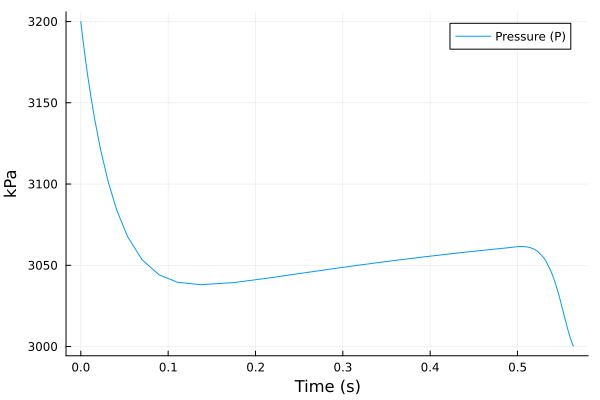

In [29]:
plot_the_res(sol_real)